### Prédire l'attrition

In [8]:
from pyspark.sql.functions import corr
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession

In [11]:
# File location and type
spark = SparkSession.builder.appName('attrition analysis').getOrCreate()
file_location = "HR-Employee-Attrition.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

DataFrame[Age: string, Attrition: string, BusinessTravel: string, DailyRate: string, Department: string, DistanceFromHome: string, Education: string, EducationField: string, EmployeeCount: string, EmployeeNumber: string, EnvironmentSatisfaction: string, Gender: string, HourlyRate: string, JobInvolvement: string, JobLevel: string, JobRole: string, JobSatisfaction: string, MaritalStatus: string, MonthlyIncome: string, MonthlyRate: string, NumCompaniesWorked: string, Over18: string, OverTime: string, PercentSalaryHike: string, PerformanceRating: string, RelationshipSatisfaction: string, StandardHours: string, StockOptionLevel: string, TotalWorkingYears: string, TrainingTimesLastYear: string, WorkLifeBalance: string, YearsAtCompany: string, YearsInCurrentRole: string, YearsSinceLastPromotion: string, YearsWithCurrManager: string]

In [12]:
print(df.count(), len(df.columns))

1470 35


In [13]:
from pyspark.sql.functions import col

# convertir les colonnes string en double quand cela est possible
for column in df.columns:
    try:
        if int(df.select(column).first()[0]):
            df = df.withColumn(column, col(column).cast("double"))
    except:
        pass

In [14]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Age,1470,36.923809523809524,9.135373489136729,18.0,60.0
Attrition,1470,None,None,No,Yes
BusinessTravel,1470,None,None,Non-Travel,Travel_Rarely
DailyRate,1470,802.4857142857143,403.50909994352804,102.0,1499.0
Department,1470,None,None,Human Resources,Sales
DistanceFromHome,1470,9.19251700680272,8.10686443566608,1.0,29.0
Education,1470,2.912925170068027,1.0241649445978718,1.0,5.0
EducationField,1470,None,None,Human Resources,Technical Degree
EmployeeCount,1470,1.0,0.0,1.0,1.0


In [16]:
num_col = []

# convertir les colonnes string en double quand cela est possible
for column in df.columns:
    try:
        if int(df.select(column).first()[0]):
            num_col += [column]
    except:
        pass

### Analyse des corrélations

In [17]:
# Calcul de la corrélation de Pearson entre chaque paire de colonnes
correlations = {}
for i in range(len(num_col)):
    for j in range(i+1, len(num_col)):
        col_i = num_col[i]
        col_j = num_col[j]
        corr_val = df.select(corr(col_i, col_j)).collect()[0][0]
        correlations[(col_i, col_j)] = corr_val

# Affichage des résultats
for cols, corr_val in correlations.items():
    print("La corrélation de Pearson entre {} et {} est : {}".format(cols[0], cols[1], corr_val))

La corrélation de Pearson entre Age et DailyRate est : 0.010660942645538433
La corrélation de Pearson entre Age et DistanceFromHome est : -0.0016861201480871592
La corrélation de Pearson entre Age et Education est : 0.2080337310142398
La corrélation de Pearson entre Age et EmployeeCount est : None
La corrélation de Pearson entre Age et EmployeeNumber est : -0.0101454670768599
La corrélation de Pearson entre Age et EnvironmentSatisfaction est : 0.010146427861437268
La corrélation de Pearson entre Age et HourlyRate est : 0.024286542550967197
La corrélation de Pearson entre Age et JobInvolvement est : 0.029819958629590578
La corrélation de Pearson entre Age et JobLevel est : 0.5096042284323842
La corrélation de Pearson entre Age et JobSatisfaction est : -0.00489187714868713
La corrélation de Pearson entre Age et MonthlyIncome est : 0.4978545669265801
La corrélation de Pearson entre Age et MonthlyRate est : 0.02805116713392273
La corrélation de Pearson entre Age et NumCompaniesWorked est :

In [0]:
# La corrélation de Pearson entre JobLevel et MonthlyIncome est : 0.9502999134798473
# La corrélation de Pearson entre JobLevel et TotalWorkingYears est : 0.7822078045362748
# La corrélation de Pearson entre YearsAtCompany et YearsInCurrentRole est : 0.7587537366134618
# La corrélation de Pearson entre PercentSalaryHike et PerformanceRating est : 0.7735499964012664

### Vérifier le nb de valeurs nulls

In [21]:
df

DataFrame[Age: double, Attrition: string, BusinessTravel: string, DailyRate: double, Department: string, DistanceFromHome: double, Education: double, EducationField: string, EmployeeCount: double, EmployeeNumber: double, EnvironmentSatisfaction: double, Gender: string, HourlyRate: double, JobInvolvement: double, JobLevel: double, JobRole: string, JobSatisfaction: double, MaritalStatus: string, MonthlyIncome: double, MonthlyRate: double, NumCompaniesWorked: double, Over18: string, OverTime: string, PercentSalaryHike: double, PerformanceRating: double, RelationshipSatisfaction: double, StandardHours: double, StockOptionLevel: string, TotalWorkingYears: double, TrainingTimesLastYear: string, WorkLifeBalance: double, YearsAtCompany: double, YearsInCurrentRole: double, YearsSinceLastPromotion: string, YearsWithCurrManager: double]

In [32]:
from pyspark.sql.functions import col, sum
# Comptage du nombre de valeurs nulles pour chaque colonne
null_counts = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
display(null_counts)

DataFrame[Age: bigint, Attrition: bigint, BusinessTravel: bigint, DailyRate: bigint, Department: bigint, DistanceFromHome: bigint, Education: bigint, EducationField: bigint, EmployeeCount: bigint, EmployeeNumber: bigint, EnvironmentSatisfaction: bigint, Gender: bigint, HourlyRate: bigint, JobInvolvement: bigint, JobLevel: bigint, JobRole: bigint, JobSatisfaction: bigint, MaritalStatus: bigint, MonthlyIncome: bigint, MonthlyRate: bigint, NumCompaniesWorked: bigint, Over18: bigint, OverTime: bigint, PercentSalaryHike: bigint, PerformanceRating: bigint, RelationshipSatisfaction: bigint, StandardHours: bigint, StockOptionLevel: bigint, TotalWorkingYears: bigint, TrainingTimesLastYear: bigint, WorkLifeBalance: bigint, YearsAtCompany: bigint, YearsInCurrentRole: bigint, YearsSinceLastPromotion: bigint, YearsWithCurrManager: bigint]

### Analyse exploratoire des données

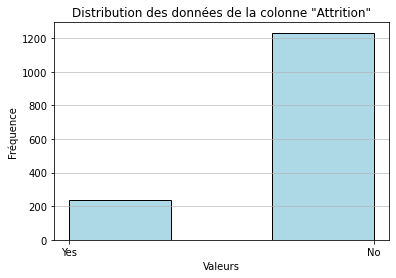

In [28]:
import matplotlib.pyplot as plt


# Conversion de la colonne "attrition" en un objet Pandas DataFrame et tracé de l'histogramme
pandas_df = df.select("Attrition").toPandas()
plt.hist(pandas_df["Attrition"], bins=3, color='lightblue', edgecolor='black')

# Personnalisation de l'histogramme
plt.title('Distribution des données de la colonne "Attrition"')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Affichage de l'histogramme
plt.show()

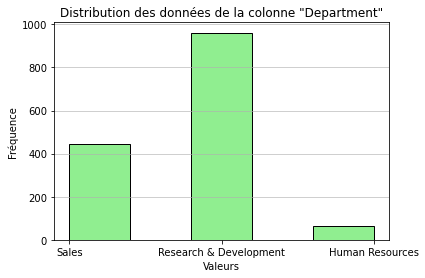

In [29]:
# Conversion de la colonne "attrition" en un objet Pandas DataFrame et tracé de l'histogramme
pandas_df = df.select("Department").toPandas()
plt.hist(pandas_df["Department"], bins=5, color='lightgreen', edgecolor='black')

# Personnalisation de l'histogramme
plt.title('Distribution des données de la colonne "Department"')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Affichage de l'histogramme
plt.show() 

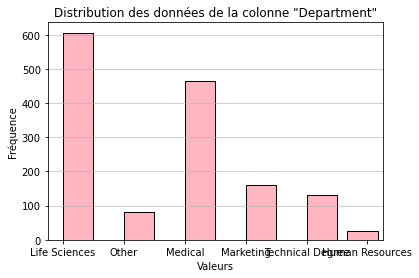

In [30]:
# Conversion de la colonne "attrition" en un objet Pandas DataFrame et tracé de l'histogramme
pandas_df = df.select("EducationField").toPandas()
plt.hist(pandas_df["EducationField"], bins=15, color='lightpink', edgecolor='black', width=0.5)

# Personnalisation de l'histogramme
plt.title('Distribution des données de la colonne "Department"')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Affichage de l'histogramme
plt.show() 

### enlever les valeurs aberrantes

In [35]:
from pyspark.sql.functions import stddev, avg

# Boucle pour enlever les valeurs aberrantes de chaque colonne
for col in df.columns:
    # Calcul des statistiques pour la colonne
    stats = df.select(avg(col), stddev(col)).first()
    mean = stats[0]
    std = stats[1]

    if mean is not None and std is not None:
    # Calcul du seuil pour déterminer les valeurs aberrantes
        threshold = 3 * std + mean
        # Suppression des valeurs aberrantes pour la colonne
        df = df.filter(df[col] <= threshold)

# Affichage du DataFrame sans les valeurs aberrantes
df.show(3)

+----+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
| Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBala

In [39]:
print(df.count(), len(df.columns))

1151 35
